## Client Requirements
Your report (in the discussion section) must include the following:

Some discussion of the features that are most important for predicting a cancelation - we do not need discussion of specific coefficient values but direction of the effect should be clear (e.g. the earlier a booking is made the more likely it is to be canceled).

A validated assessment of your model's performance, but this must be specifically discussed in the context of bookings and running a hotel. It is not sufficient to report summary statistics like the accuracy or AUC - you must address the perfomance in terms of potential gains and losses for the hotel (e.g. think about what happens if your model predicts a cancelation that does not actually occur and a room ends up being double booked or vice versa). Explain why you think your particular model would or would not be economically viable.

# Planning Markdown
Where to write what we are going to do & how - so that others can puck this up and we can code togteher

Feature engineering 
To Do:
* Handle the nan data in country & FX Data. likely have to make up some sort of assumption to get ride of these, even though these are small countries which may remove the diversity of the data. `ACTION:` Need to make a decision on this
* Once we have all of the data we need to Plot it to then justify the model. Ideas for plotting:
    - Is_cacelled percentage heat map of the world. Use plotly. (for each hotel)
    - Distance travelled to hotel vs Is Cancellation  (for each hotel)
    - Rolling month cancellation vs non-cancellation (for each hotel)

things to do:

* `Done` Concat Marget Segment & distribution-channel DONE
* `Done` Name agent ID & Company ID for box plot 
* Find something to  plot in the spider 
* `Done` Delete the arriva date week number & arrival date day of month DONE?
* `Done` Extract a percentage of the countries and label as their actual country, and label the rest as other.  
* `Done` Create DF of differnt coef's - this can then be used & we run repeatable a function to then get the one-hot-coded feature names back into shape and then we can plot various fields like market segment/country etc against on another. 
* Discuss - is previous cancellation now accurate now that we are taking out agent/company? YES KEEP IT! HAHA! 


# Machine Learning in Python - Project 2


Finlay Young, Rachel Dance, Silvia Cecilia Hernandez Vargas

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [98]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np
import geopy.distance as gpy
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import pycountry as pyc
import ccy

#Web Scraping Requirement
import datapackage

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

# Imported Packages 

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier

import urllib
import base64
from io import BytesIO, StringIO

In [99]:
# Load data
d = pd.read_csv("hotel.csv")


## 1. Introduction

In this project we analyse hotel booking data as given in the file 'hotel.csv'. This data is collected by [Antonio, Almeida and Nunes, 2019](https://www.sciencedirect.com/science/article/pii/S2352340918315191#f0010). This data was gathered for hotels located in Portugal: H1 at the resort region of Algarve and H2 at the city of Lisbon - and is extracted from "hotels.csv". There are 119,390 datapoints between July 1st, 2015 through August 31st 2017.

A full description of additional datasetsis given in Section 2b, but briefly here we imported other datasets as follows in order to enhance our analysis:
- 'currency_exchange_rates_02-01-1995_-_02-05-2018.csv' - the exchange rates between Jan 1995, and May 2018
- 'ISO 3155' - country three letter codes
- 'countries_coords' - central coordinates of countries in dataset
- 'curr_codes' - codes depicting country currencies

Our data cleaning approach is to... 

Our modeling approach is to.... 

Our key conslusions are ... 

Our limitations are... 

## 2. Exploratory Data Analysis and Feature Engineering

### Data Cleaning
#### Core issues

Upon initial analysis the following steps were taken to clean the source data which included many null values, or incorrectly populated.  these columns were: children , country , agent , company - resulting in 87138 rows of incomplete data entries. 


|variable                       |description of data cleaning  |
|:------------------------------|:-----------|
|  `Children`                | nan valued children were replaced with zeros - this makes the assumption of an error in data entry, i.e. it was omitted when filling this field in for no children. |
|`company` & `agent`  |96% of this variable is null and shall be removed from the Dataset. Given that many `agent` values would correspond to a specific company, this still allows for the sale/a cancellation to attributed a to a known agent with more granularity than `company`. Agent, company & the means of a booking are further analysed, but from the outset the company field is removed due to poor data. Agent is also sparsly populated, and therefore also required further analysis |
|`country`                           | Null country codess have been assumed to default to PRT (Portugal), given that the hotels are in Portugal and make up 32% of all bookings; Of ~190,00 row, this is a fair rough assumption given there are only 415 'nan' countries. The variable should follow a 3 character code (ISO 3155) however there is an alpha-2 code for "CN", which is corresponds to China. This has been changed from "CN" to "CNH"   |
||



There are ~32,500 duplicate rows of data. In the interest of meeting the clients requirements, we are investigating what will indicate cancellations, and not the overall booking. It would be fair to assume these were all "double bookings" where multiple groups of friends (or coincidental) booking for the same holiday in different transactions, or for a popular event - for this reason we will not be dropping these duplicates. The other reason for not dropping the duplicates is because 90% of the duplicates are reservations for the City hotel, which would remove potentially useful data. 

In [100]:
#preprocessing string values 
#d['distribution_market'] = d["distribution_channel"]+ " - " + d["market_segment"].map(str)
#d = d.drop(['market_segment', 'distribution_channel'], axis=1)
d['company'] = np.where((d.company.isnull()),np.nan,'Company ID: '+ d["company"].map(str))
d['agent'] = np.where((d.agent.isnull()),np.nan,'agent ID: '+ d["agent"].map(str))
d['children'] = np.where(d['children'].isnull(),0,d['children'])
d['country'] = d['country'].replace(np.nan, 'OTHER')


Dealing with the date/time data - here we reformat the dates and times to split into individual features, and adding them to the dataframe `d`.

In [101]:
#format arrival date
d['month'] = pd.to_datetime(d.arrival_date_month, format='%B').dt.month
d['day'] = pd.to_datetime(d.arrival_date_day_of_month, format='%d').dt.day
d['Year'] = pd.to_datetime(d.arrival_date_year, format='%Y').dt.year
d['arrival_date']  = pd.to_datetime(d[['Year','month','day']], format = '%Y%m%d')#.dt.date
d['booking_date'] = d['arrival_date'] - pd.to_timedelta(d['lead_time'], unit='d')

min_date = d['arrival_date'].min()
max_date = d['arrival_date'].max()
min_booking_date = d['booking_date'].min()

#### Booking type

In this table, we can see that there is a lot of overlap between the `distribution_channel` and `market_segment`, where the latter is the parent field. We also see a similar overlap with `company` and `agent` - there are agents in which the same agent appears in multiple companies. We further visualise this below in the figure.

In this section we analyse further the dependency of `country`,`market_segment`, `company`, `agent` and `distribution_channel`. We summarise the data below.

In [102]:
#spider
d_cat_cut = d.groupby(['distribution_channel', 'market_segment']).agg({'meal':'count'}).reset_index()
d_cat_cut.rename(columns = {'meal' : 'Counts'}, inplace = True)

fig = px.parallel_categories(d_cat_cut, color="Counts", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

In [103]:
# Table data showing the market sector, company and agent dependency
# Visualisation of table data:

booking_means = d.groupby(['market_segment',"company", "agent",]).agg({'meal':'count'}).reset_index()
booking_means.rename(columns = {'meal' : "Counts"}, inplace = True)
fig = px.treemap(booking_means, path=['market_segment',"company", "agent",], values='Counts')
fig.show()

In [104]:
market_retain = ['Online TA', 'Offline TA/TO', 'Groups', 'Direct', 'Corporate']
d['market_segment'] = np.where( d['market_segment'].isin(market_retain) , d['market_segment'], 'Other')

On this basis, we have concatenated the fields of `market_segment` and `distribution channel` to preserve the information and reduce features. We shall drop the `agents` and `company` fields, as they add complexity to the data but not necessarily adding much in the way of insight. For example, the agent ID values show dubplicate agents for multiple companies, 

#### Room types (booked)

In [105]:
fig = px.sunburst(d.groupby(['hotel','reserved_room_type','assigned_room_type',]).agg({'is_canceled':'sum'}).reset_index(),
                    path = ['hotel','reserved_room_type', 'assigned_room_type',],
                    values = 'is_canceled',
                    title = ' Hotels ')

fig.show()

#### Spider Diagram

Were still looking for a reason to use this!

In [106]:
d_cat_cut = d.groupby(['hotel','children', 'babies']).agg({'is_canceled':'sum'}).reset_index()
d_cat_cut.rename(columns = {'is_canceled' : 'Counts of cancellation'}, inplace = True)

fig = px.parallel_categories(d_cat_cut, color="Counts of cancellation", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

#### Cancellations by country
Here we look to see proportionally whether most cancellations originate in one or two countries. We plot a map which visualises data by year. We can see by moving the slider that this varies  from year to year. We do not include the year of booking in the modeling as, for example, saying that a booking made in 2015 is more likely to be canceled is meaningless for prediction.

In [9]:
map_data = d.groupby(['country', 'hotel', 'arrival_date_year',]).agg({'arrival_date_month':'count', 'is_canceled':'mean'}).reset_index()
map_data.rename(columns = {'arrival_date_month': 'Total_booking', 'is_canceled': 'Cancellation_proportion'}, inplace = True)
map_data.sort_values(by=['arrival_date_year'], inplace=True)
fig = px.choropleth(map_data, locations="country", color="Cancellation_proportion", hover_name="Total_booking", 
                    animation_frame="arrival_date_year", range_color=[0,1], width = 1300 , height= 600,
                    title ='Proportion of cancellations per country years 2015, 2016 & 2017' )
fig.show()

#### Booking date

The date of the booking and of the hotel stay is kept in the dataframe, but arrival year & week number are omitted. Year is non-sensical as described above, and the week number is a duplication of information we can more meaningfully obtain from the month of the booking. The month feature is more than adequate feature to identify seasonal changes. The dataset consists of 24 months of data spanning three years, and as such we only have one complete year, so we cannot do a comparison of a set month over the three years, but we will keep month as a feature.

We do a short analysis here of the bookings by looking at cancellations across the months in the set.

KeyboardInterrupt: 

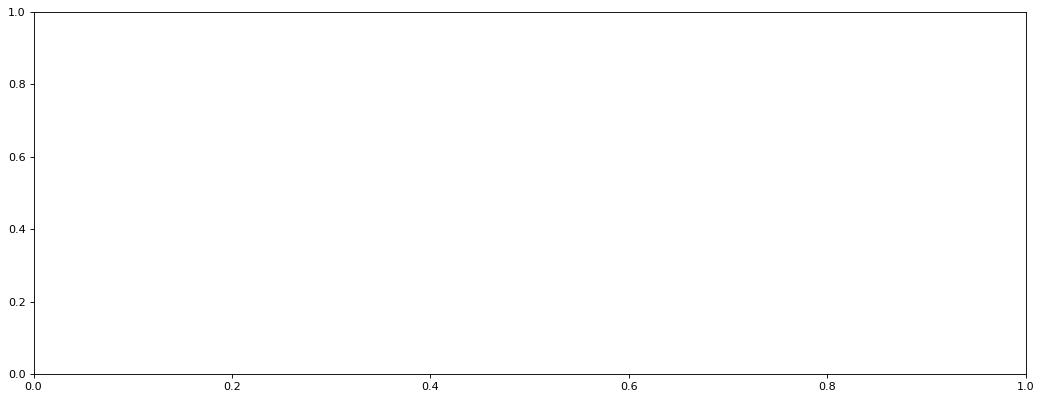

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x ='arrival_date_month', y = 'adults',hue = "is_canceled", data = d)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

This plot briefly shows that we dont have a strong dependence on month of booking. 

### Additional Data sources & pre-processing

Aside from cleaning & preprocessing the main hotels data, there was considerable processing of data which was join to give additional features. See below for a summary of these additional datsets. 

|Dataframe                       |Column |
|:------------------------------|:-----------|
|fx_rates                   | This is a datafram of daily currency Exchange rates from 1995 - 2018, for 50+ currencies, with an exchange rate with respect to US Dollars . | 
|cur_code                          | This dataframe has the currency Name & the Currency 3-Alpha code Source: https://developers.google.com/public-data/docs/canonical/countries_csv    |
|coords             |This Dataframe holds the Alpha-2 char code and the central point of the country with a feature for Longditude & Latitude. |
|comp_countries | This DataFrame hold geographical data as well as multiple naming conventions for each country. This also Hold the main currency code for each country. Source: https://datahub.io/core/country-codes  |

In [107]:
cur_code = pd.read_csv("curr_codes.csv")
countries_name = pd.read_csv("ISO 3155.csv")
coords = pd.read_csv("countries_coords.csv")
fx_rates = pd.read_csv("/work/currency_exchange_rates_02-01-1995_-_02-05-2018.csv")

data_url = 'https://datahub.io/core/country-codes/datapackage.json'
# to load Data Package into storage
package = datapackage.Package(data_url)
# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        comp_countries = pd.read_csv(resource.descriptor['path'])


|Dataframe                       |Description of prerocessing  |
|:------------------------------|:-----------|
|cur_code | This dataset was used to enrich fx_rates with the Aphabetic Currency code. The preprocessing here was an iterative task, and involved renaming many of the currencies within fx_rates to ensure a match, which would then allow for the enriched fx_rates . |
||
|coords  | Using the Longditude & Latitude we were able to calculate the Orthodoric (spherical) distance between each country of the world to Portugal, where both the hotel resorts are. This distance in kilometers was then able to be joined onto the main 'Hotels.csv' dataset. This enrichment will be able to give further depth & understanding on each guests decision to cancel if we assume that a greater distance implies a longer transportation time, and more expensive means of transportation.  |
||
|comp_countries | The majority dataset was not used, the data in this dataset was for mapping data between 'hotels.csv' and coords and fx_date to ensure that there are consistent country & currency codes to join on.|
||
|fx_rates | Given that there are exchange rates from 1995 - 2018, this data needed to be cut down to start at the earliest booking date from 'hotels.csv' up to the last arrival date.The rationale for this was to ensure we could enrich the main dataset with an exchange rate from the customers home currency at the point of booking their holiday (booking date) and compare this with an exchange rate percentage on their arrival (arrival date) of their holiday. The data required to first be calculated from US Dollar exchange rates into Euro exchange rates. The data also had many missing dates, which were sundays, which meant that many arrival & booking dates were not within the fx_rates dataset. To fix this, all dates were added between the first booking date & arrival date, and the missing exchange rates were linearly interpolated.  |

In [108]:
# Join comp_countries data to d (main)
comp_countries = comp_countries.loc[:, ['ISO3166-1-Alpha-3',
                                'ISO3166-1-Alpha-2',
                                'ISO4217-currency_country_name',
                                'ISO4217-currency_alphabetic_code',
                                'Region Name',
                                'Continent']]
d = pd.merge(d,comp_countries,left_on='country', right_on='ISO3166-1-Alpha-3', how = 'left')
d.rename(columns = {'ISO4217-currency_alphabetic_code' : 'Currency_code'}, inplace = True)

#Reform Co-Ordinates into list within DF
coords['co_ords'] =  coords[['latitude', 'longitude']].values.tolist()
coords = coords.dropna()

# Set Portugal as basis
portugal = coords['co_ords'].loc[coords["name"] == 'Portugal'].values.tolist()

#Compute the distance in KM from all countries to Portugal
coords['distance(km)'] = coords.apply(lambda coords: gpy.great_circle(portugal,
                                                             coords['co_ords']).km,
                                                            axis = 1).round(decimals=2)
# Join to main Dataframe
coords_cut = coords[['country','distance(km)']]
coords_cut.columns = ['ISO3166-1-Alpha-2','distance(km)']
d = pd.merge(d,coords_cut ,on='ISO3166-1-Alpha-2', how = 'left')

#Rename the columns within FX Rates Column
#Select Columns from cur_code
cur_code = cur_code.loc[:, ['country Entity','Currency','AlphabeticCode']]

# Get all FX Rate currency codes (don't include Date field)
fx_codes = pd.DataFrame(fx_rates.columns[1:], )

#Test the results of the merge codes which match well currently
cur_mapping_test = pd.merge(fx_codes,cur_code,left_on=0, right_on='Currency', how = 'left') 

#check for non matching
#sorted(cur_mapping_test[0][cur_mapping_test['Currency'].isna()])
# Create Update Dict:
null_curr_map = sorted(cur_mapping_test[0][cur_mapping_test['Currency'].isna()])
new_curr_map = ('Bahraini Dinar',
                'Pula',
                'Yuan Renminbi',
                'Forint',
                'Iceland Krona',
                'Rupiah',
                'New Israeli Sheqel',
                'Yen',
                'Tenge',
                'Won',
                'Mauritius Rupee',
                'Pakistan Rupee',
                'Zloty',
                'Qatari Rial',
                'Saudi Riyal',
                'Rand',
                'Baht',
                'Trinidad and Tobago Dollar',
                'UAE Dirham',
                'Pound Sterling',
                'US Dollar',
)
# Create Dataframe to update old values within FX Code to (i) join to Main and (ii) update fxrate columns
fx_rename = dict(zip(null_curr_map, new_curr_map))

# Update FX Rates - ready for updateing fx rates
fx_rates.rename(columns = fx_rename, inplace = True)

# You need this mapping for when the FX Rate data is processed & pivoted. 
cur_mapping =  pd.merge(fx_codes,cur_code,left_on=0, right_on='Currency', how = 'left') 

Exchange rates for all common currencies have been sourced from 1995 - 2018. This data is used to investigate the strength of a guests currency from the time of booking, to when the holiday is close by. This requires some preprocessing of the data for it to be added to the main dataset. 

In [109]:
#Reformat Date column
fx_rates['Date'] = pd.to_datetime(fx_rates['Date'], format='%Y-%m-%d')
#fx_rates['Date']  = pd.to_datetime(fx_rates['Date']).dt.date

#Reform into Euro conversion rates  
fx_rates.iloc[:,1:] = fx_rates.iloc[:,1:].div(fx_rates.Euro, axis=0)

#Cut Dates so that theres only the date from the earliest booking to the last booking
fx_rates = fx_rates[fx_rates['Date'].between(min_booking_date,max_date)]

# Create rows full of "nan" for the missing dates within range 
fx_rates = pd.merge(pd.DataFrame({"Date" : pd.date_range(min_booking_date, max_date, freq='D')}),fx_rates ,left_on='Date', right_on='Date', how = 'outer')

# Interpolate to remove missing true null values  and newly created values for dates
fx_rates = fx_rates.interpolate()

#Pivot Data vertically 
fx_rates = fx_rates.melt(id_vars = ['Date'],var_name='Currency', value_name='FX_Rates')

# Join to get currency code
d.rename(columns = {'ISO4217-currency_alphabetic_code' : 'Currency_code'}, inplace = True)
cur_code.rename(columns = {'AlphabeticCode' : 'Currency_code'}, inplace = True)
fx_rates = pd.merge(fx_rates, cur_code,on='Currency', how = 'left')
fx_rates = fx_rates[['Date','Currency','Currency_code','FX_Rates']]

fx_rates = fx_rates.drop_duplicates()

# get FX rate as at arrival date
d = pd.merge(d, fx_rates,left_on=['Currency_code','arrival_date'], right_on = ['Currency_code','Date'] ,how = 'left' )
d.rename(columns = {'FX_Rates' : 'FX_Rates_on_arrival'}, inplace = True)
# get FX rate as at booking date
d = pd.merge(d, fx_rates,left_on=['Currency_code','booking_date' ], right_on = ['Currency_code','Date'],how = 'left' )
d.rename(columns = {'FX_Rates' : 'FX_Rates_on_booking'}, inplace = True)
d.drop(['Currency_x'],axis =1, inplace=True )
# Drop useless columns from merges 
d.drop(['Date_x','Date_y'],axis =1, inplace=True )
# Calculate the % Loss between Booking & Arrival Dates
d['FX_Delta'] = np.where(((d.Currency_code =='EUR')|(d['FX_Rates_on_arrival'] - d['FX_Rates_on_booking'] ==0)),0, (d['FX_Rates_on_arrival'] - d['FX_Rates_on_booking'])/ d['FX_Rates_on_booking'])


### Data analysis & feature engineering refinements

The below plot shows the values which have unoptained currecny exchange rates because the country's currency data is not readily available (for free). For this reason, we have assumed a 0 value to populate in all the FX rate difference between the booking & arrival date. This is not a perfect assumption, as these currencies are likley to more volatile, however there are only ~4000 instances out of the ~119,000 reservations. 

In [110]:
x = d[d['FX_Rates_on_arrival'].isna()] 
fig = px.sunburst(x.groupby(['hotel','ISO4217-currency_country_name','Continent',]).agg({'Currency_code':'count'}).reset_index(),
                    path = ['hotel','Continent', 'ISO4217-currency_country_name',],
                    values = 'Currency_code',
                    title = 'Distribution of countries with missing currency data')
fig.show()
#missing_currencies


The following fields are to be dropped given that their purpose has been served, and are efficeivley duplicate feaures which are dependant datapoints:

(comment on the treatment & show plots before dropping these fields)


In [15]:
fig = px.sunburst(d.groupby(['hotel','is_canceled','arrival_date_month',]).agg({'ISO4217-currency_country_name':'count'}).reset_index(),
                    path = ['hotel', 'is_canceled','arrival_date_month',],
                    values = 'ISO4217-currency_country_name',
                    title = 'Regional Distribution between Hotels ')

fig.show()

#### Dropping fields post processing

There exists data where the feature 'adr' contains zero as a value, which we might expect to be an error in the data as it is not possible to have no expenses during the accomodataion. Our first attempt was to replace this 'zero' values with the average expenses given the reserved room type, assigned room type and type of meal. However, the percentage of the data with no value is low in comparison with the whole data. Therefore, we decided to delete the rows which this characteristic from the data.

In [111]:
no_adr = d[d['adr']==0]
print('Percentage of data with no value in the Average Daily Rate is:', round((no_adr ['adr'].count()/d['adr'].count())*100,2), '%')

Percentage of data with no value in the Average Daily Rate is: 1.64 %


In [112]:
fig = px.sunburst(d.groupby(['hotel','ISO4217-currency_country_name',]).agg({'is_canceled':'count'}).reset_index(),
                    path = ['hotel', 'ISO4217-currency_country_name',],
                    values = 'is_canceled',
                    title = 'Regional Distribution between Hotels ')

fig.show()

#### Hunting dependencies...


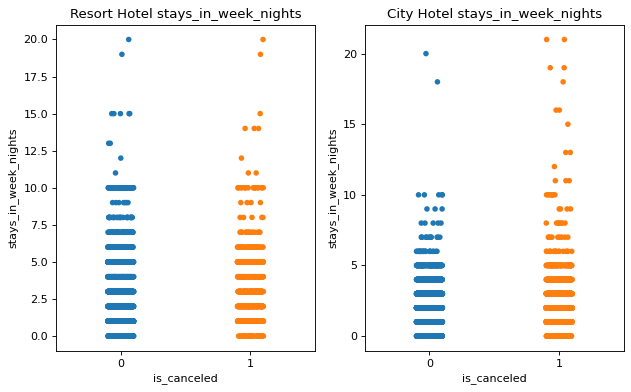

In [113]:
# Needs dataframe d_samp - a sample from the original dataframe d
# Take a sample from 
d_samp = d.sample(frac=0.1, random_state=1234)
fig = plt.figure()

curr_var = 'stays_in_week_nights'

ax1 = fig.add_subplot(121)
g = sns.stripplot(x="is_canceled", y = curr_var, data=d_samp[d_samp['hotel']== "Resort Hotel"], ax = ax1)
ax1.set_title(f'Resort Hotel {curr_var}') 

ax2 = fig.add_subplot(122)
g = sns.stripplot(x="is_canceled", y = curr_var, data=d_samp[d_samp['hotel']== "City Hotel"], ax = ax2)
ax2.set_title(f'City Hotel {curr_var}') 

plt.close(2)
plt.close(3)
plt.tight_layout()

In [114]:
#Violin plot as we have LOTS of datapoints - lead times

# Create a sub dataframe of the things we want (so i can log some)
vars_of_interest=['lead_time','babies','children']
sub_d_samp = pd.merge(d_samp[['is_canceled','hotel']], d_samp[vars_of_interest], on = d_samp.index)
sub_d_samp['log_lead_time'] = np.log(sub_d_samp.lead_time)
#Children field is some messed up type so cast as int here
sub_d_samp['children'] = sub_d_samp['children'].astype(int) 

# #append any logged columns to sub_dataframe - AGH ERRORS. Fuck this.
# vars_of_interest.append('log_lead_time')
# sub_d_samp[sub_d_samp['log_lead_time'] < 0] = 1E-6
# # sub_d_samp.iloc[6]
# type(sub_d_samp['log_lead_time'][0])
min(sub_d_samp['log_lead_time'])

/usr/local/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



-inf

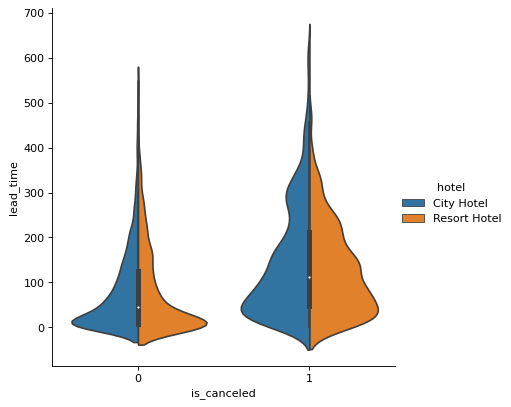

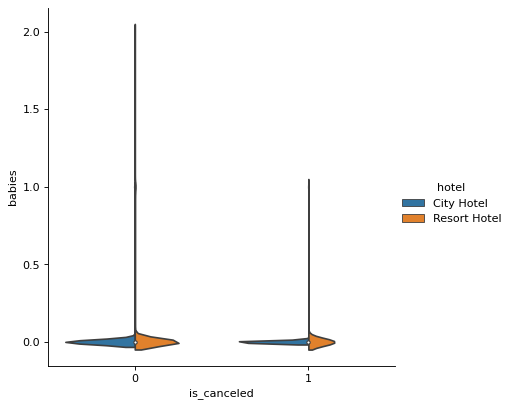

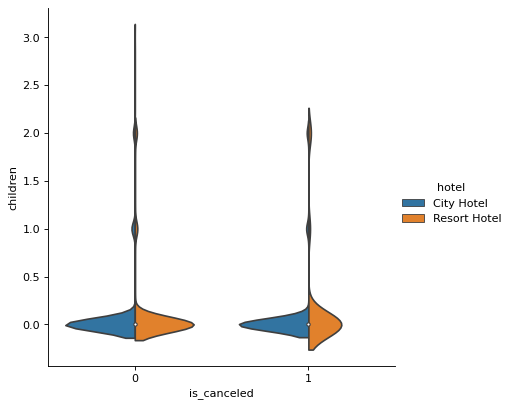

In [ ]:
#Plot for all variables in list - cant do subplots??
for violin_var in vars_of_interest:
    g = sns.catplot(x = "is_canceled", y = violin_var, data = sub_d_samp, split = True, hue = 'hotel', kind = "violin", scale = 'area')
    # g.set_title(f'Variable: {violin_var}')


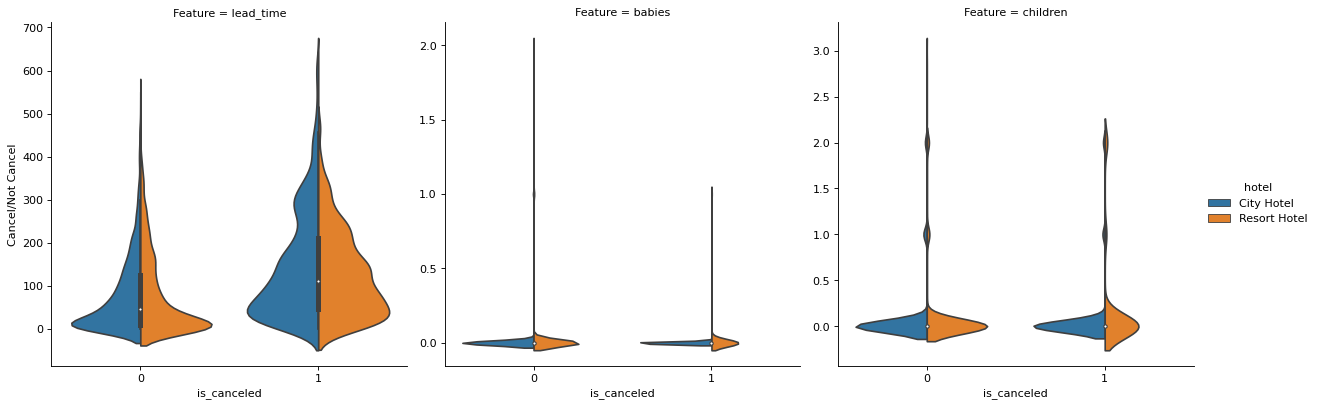

In [20]:
g = sns.catplot( data = sub_d_samp.melt(id_vars = ['is_canceled','hotel'],value_vars = ['lead_time','babies','children'],var_name = 'Feature',value_name = 'Cancel/Not Cancel'),
                    x = 'is_canceled', y = 'Cancel/Not Cancel', hue = 'hotel', kind = 'violin', col = 'Feature' , scale = 'area', sharey= False, split=True)


So far: (plots scaled by area? Is this ok?)
- 'babies - that in both set of hotels, babies is almost always 0 - vioin plot is bad! 
- lead time - in both hotels the is canceled tapers off with lead time - i.e. are people more likely to cancel the later they book it - is this because it was done in a rush and didnt think about it? Longer lead times tend to keep their bookings
- 'children' - wtf is going on there?!

Combining `reserved_room_type` and `assigned_room_type` into asingle binary field that shows whether they are the same or not, i.e. did the customer get what they asked for.

In [115]:
d['room_granted'] = np.where(d["reserved_room_type"] == d["assigned_room_type"], True, False)


##### Country analysis
How many times do the agents appear each? If an agent doesnt appear in 10% of the data or more, they are assigned to 'other agents', as its is not deemed to be predictive if it is sparsely spread in the data.

In [116]:
num_countries = d['country'].nunique()
print(f'There are {num_countries} countries in the original data')

There are 178 countries in the original data


unique countries ===  178


Text(0.5, 0, 'Country code (unreadable, we are just looking at distribution)')

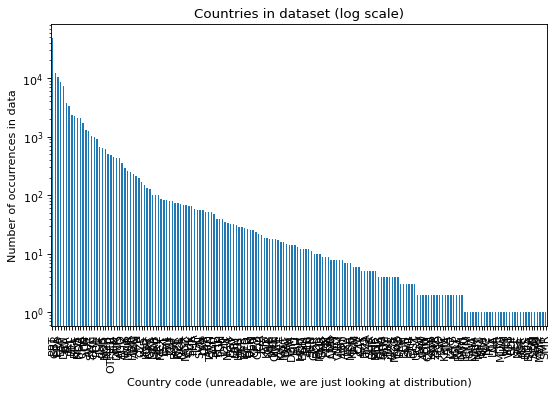

In [117]:
#Look at the countries in the dataset:
# agents are appearing only one time then they are pointless like in project 1
print('unique countries === ', d['country'].nunique())
var_count_df = d.country.value_counts()
#plot
var_count_df.plot.bar(var_count_df, logy=True)
plt.title('Countries in dataset (log scale)')
plt.ylabel('Number of occurrences in data')
plt.xlabel('Country code (unreadable, we are just looking at distribution)')


In [118]:
percent_to_keep = 0.05
print(f'We are keeping {percent_to_keep*100}% of {len(var_count_df)} countries. These are:')
var_count_df[var_count_df > (percent_to_keep*len(d['country']))]

We are keeping 5.0% of 178 countries. These are:


PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
Name: country, dtype: int64

In [119]:
# Create list of countries to remove (compliment of previous line)
var_count_df = var_count_df[var_count_df < (percent_to_keep*len(d['country']))]
# Get indices of the ones to keep
indices_ = []
for i in range(len(var_count_df)):
    indices_.append(var_count_df.index[i])
print('Indices to drop: \n',list(indices_))

Indices to drop: 
 ['ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA', 'CHE', 'CN', 'AUT', 'SWE', 'CHN', 'POL', 'ISR', 'RUS', 'NOR', 'ROU', 'OTHER', 'FIN', 'DNK', 'AUS', 'AGO', 'LUX', 'MAR', 'TUR', 'HUN', 'ARG', 'JPN', 'CZE', 'IND', 'KOR', 'GRC', 'DZA', 'SRB', 'HRV', 'MEX', 'EST', 'IRN', 'LTU', 'ZAF', 'BGR', 'NZL', 'COL', 'UKR', 'MOZ', 'CHL', 'SVK', 'THA', 'ISL', 'SVN', 'LVA', 'CYP', 'ARE', 'TWN', 'SAU', 'PHL', 'SGP', 'TUN', 'IDN', 'NGA', 'EGY', 'URY', 'LBN', 'HKG', 'PER', 'MYS', 'ECU', 'BLR', 'VEN', 'CPV', 'GEO', 'JOR', 'CRI', 'KAZ', 'GIB', 'MLT', 'OMN', 'AZE', 'KWT', 'MAC', 'QAT', 'PAK', 'DOM', 'IRQ', 'BIH', 'MDV', 'BGD', 'PRI', 'ALB', 'SEN', 'CMR', 'BOL', 'MKD', 'GNB', 'PAN', 'TJK', 'CUB', 'ARM', 'JEY', 'VNM', 'LBY', 'AND', 'LKA', 'MUS', 'KEN', 'JAM', 'CIV', 'CAF', 'FRO', 'TZA', 'SUR', 'BHR', 'MNE', 'BRB', 'GHA', 'GTM', 'PRY', 'ZWE', 'UZB', 'MCO', 'GAB', 'TMP', 'BEN', 'LIE', 'SYR', 'ETH', 'GGY', 'UGA', 'SLV', 'IMN', 'ABW', 'COM', 'KNA', 'STP', 'ZMB', 'TGO', 'SYC', 'KHM', 'ATA', 'LAO', 'MYT',

In [120]:
#Replace the countries... 
# Look in d for entries
for i in range(len(d['country'])):
    if d['country'][i] in var_count_df:
        d['country'][i] = 'OTHER'

d['country'].unique()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['PRT', 'GBR', 'OTHER', 'ESP', 'FRA', 'DEU'], dtype=object)

In [121]:
d.corr()["is_canceled"].sort_values(ascending=False)[1:] 

lead_time                         0.293123
room_granted                      0.247770
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
FX_Delta                          0.038384
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
Year                              0.016660
month                             0.011022
arrival_date_week_number          0.008148
children                          0.005036
stays_in_weekend_nights          -0.001791
FX_Rates_on_booking              -0.002500
FX_Rates_on_arrival              -0.002575
arrival_date_day_of_month        -0.006130
day                              -0.006130
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
is_repeated_guest                -0.084793
distance(km)                     -0.134956
booking_changes                  -0.144381
required_ca

##### Required Car parking spaces

In [129]:
d['required_car_parking_spaces'].value_counts()

KeyError: 'required_car_parking_spaces'

In [ ]:
d.groupby(['required_car_parking_spaces', 'is_canceled']).agg({'is_canceled':'sum'})

is_canceled
required_car_parking_spaces is_canceled             
0                           0                      0
                            1                  44224
1                           0                      0
2                           0                      0
3                           0                      0
8                           0                      0

#### Dropping variables from the dataframe
Here we drop the variables that we do not need from the dataframe. We dont discuss all of these as some arise from the additional datasets and were never intended to be part of the modelling. 

In [122]:
# Dropping dependant fields not required for models. Full Dataset is stored in d_FULL for data analysis at the end of the models.  
d_FULL = d.copy()
d.drop(['ISO3166-1-Alpha-3',
        'ISO3166-1-Alpha-2',
        'ISO4217-currency_country_name',
        'Region Name',
        'FX_Rates_on_booking',
        'FX_Rates_on_arrival',
        'Continent',
        'Currency_code' , 'distance(km)','arrival_date' , 'booking_date',
        'arrival_date_week_number','arrival_date_day_of_month',
        'Currency_y', 'Currency_code','agent','company','day',
        'Year','month','arrival_date_year','assigned_room_type',
        'required_car_parking_spaces','distribution_channel'],axis =1, inplace=True )

d['FX_Delta'] = d['FX_Delta'].replace(np.nan, 0)

In [125]:
d.isna().any()
d.columns

Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'total_of_special_requests', 'FX_Delta', 'room_granted'],
      dtype='object')

## 3. Model Fitting and Tuning

In [127]:
#Code for onehotting 
d_onehot = d.copy()
d_onehot = pd.get_dummies(d_onehot)
d_onehot_labels =  d_onehot.columns

#d2_sample = d_onehot.sample(frac=0.01, random_state=1234)
#X = d2_sample.drop('is_canceled', axis = 1)
#y = d2_sample['is_canceled']

X = d_onehot.drop('is_canceled', axis = 1)
y = d_onehot['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_test
#d_onehot = pd.get_dummies(d2)

print("Dimension of Train set",X_train.shape)
print("Dimension of Test set",X_test.shape,"\n")
# Split Dataset into Continous and Categorical features in training set
num_cols = X_train._get_numeric_data().columns
print("Numerical Features in Dataset:",num_cols.size)
print("Categorical Features in Dataset:",(len(X_train.columns) - num_cols.size))


Dimension of Train set (95512, 63)
Dimension of Test set (23878, 63) 

Numerical Features in Dataset: 63
Categorical Features in Dataset: 0


### Logistic regression

In [130]:
# Note we use `fit_intercept = False` to avoid a rank deficient model matrix since
# we used one-hot encoding for the `number` feature.
#simple
#m = LogisticRegression(penalty = 'none', fit_intercept = False, solver='lbfgs', max_iter=1000).fit(X, y)
m = make_pipeline(
    StandardScaler(), # required for logreg
    LogisticRegression()#penalty='none', max_iter=1000, fit_intercept=False, solver='lbfgs')
)

param_grid = { 
        'logisticregression__C':  np.linspace(0.1, 10, 10)
    }

kf = KFold(n_splits=5, shuffle=True, random_state=0)
logreg_model = GridSearchCV(m, param_grid, cv= kf)
logreg_model.fit(X_train, y_train)



GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ])})

In [ ]:
Y_hat_logreg = logreg_model.predict(X_test)
#confusion_matrix(Y_hat_logreg,y_test)

NameError: name 'logreg_model' is not defined

In [ ]:
#print("Best SVC params:",logreg_model.best_params_,'\n')
#print("Training accuracy for Logistic Reg: %f" % logreg_model.score(X_train , y_train))
#print("Testing  accuracy for Logistic Reg: %f" % logreg_model.score(X_test  , y_test ))
print("accuracy:",logreg_model.best_score_,'\n')

importance_logreg = logreg_model.best_estimator_.steps[1][1].coef_[0]
coefficients_dict = dict(zip(X.columns, importance_logreg))
# View the accuracy score

print('_____ GridSearchCV Logistic Regression Model Results_____')
print("Best Logistic Regression params: ", logreg_model.best_params_)
print("Training set score for Logisitic Regression: %f" % logreg_model.score(X_train , y_train))
print("Testing  set score for Logisitic Regression: %f" % logreg_model.score(X_test  , y_test ))

# Now inspect the final model
final_model = logreg_model.best_estimator_
#Y_pred_svm = models_tree_random.predict(X_test)

print('_____ Final Logistic Regression Model Results_____')

print('_____ Confusion Matrix_____ : \n',confusion_matrix(Y_hat_logreg,y_test))
print('_____ Classification Report_____ : \n',classification_report(y_test,Y_hat_logreg))

print('Coefficients for each feature are: \n')
probs = logreg_model.predict_proba(X_test)
coefficients_dict

print('% False positive for no cancellation',round(confusion_matrix(Y_hat_logreg,y_test)[0,1]/ sum(confusion_matrix(Y_hat_logreg,y_test)[0,:]),5)*100)

print('% False positive for cancellation',round(confusion_matrix(Y_hat_logreg,y_test)[1,0]/ sum(confusion_matrix(Y_hat_logreg,y_test)[1,:]),5)*100)


accuracy: 0.8109556614911698 

_____ GridSearchCV Logistic Regression Model Results_____
Best Logistic Regression params:  {'logisticregression__C': 0.1}
Training set score for Logisitic Regression: 0.811416
Testing  set score for Logisitic Regression: 0.806851
_____ Final Logistic Regression Model Results_____
_____ Confusion Matrix_____ : 
 [[13607  3285]
 [ 1327  5659]]
_____ Classification Report_____ : 
               precision    recall  f1-score   support

           0       0.81      0.91      0.86     14934
           1       0.81      0.63      0.71      8944

    accuracy                           0.81     23878
   macro avg       0.81      0.77      0.78     23878
weighted avg       0.81      0.81      0.80     23878

Coefficients for each feature are: 

% False positive for no cancellation 19.447
% False positive for cancellation 18.995


In [ ]:
print('Probabilites:')
probs[]

Probabilites:


array([0.65570904, 0.34429096])

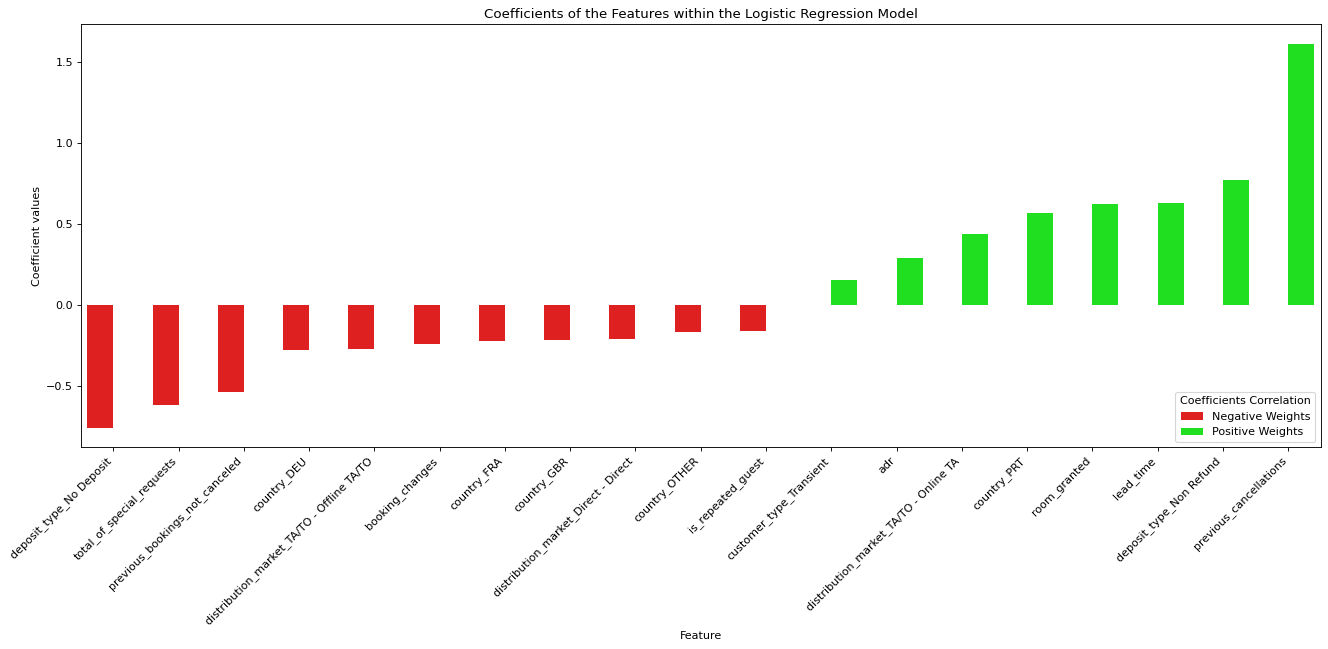

coefficients                                    Feature  \
50     -0.758281                    deposit_type_No Deposit   
12     -0.616919                  total_of_special_requests   
8      -0.537062             previous_bookings_not_canceled   
34     -0.275048                                country_DEU   
78     -0.273133  distribution_market_TA/TO - Offline TA/TO   
..           ...                                        ...   
39      0.564405                                country_PRT   
14      0.621102                               room_granted   
0       0.628807                                  lead_time   
51      0.770350                    deposit_type_Non Refund   
7       1.610069                     previous_cancellations   

   Coefficients Correlation  
50         Negative Weights  
12         Negative Weights  
8          Negative Weights  
34         Negative Weights  
78         Negative Weights  
..                      ...  
39         Positive Weights  
14         Positive Weights  
0          Positive Weights  
51         Positive Weights  
7          Positive Weights  

[83 rows x 3 columns]

In [ ]:
logReg_Coefs = pd.DataFrame(importance_logreg, columns = {'coefficients'})
logReg_Coefs['Feature'] = d_onehot_labels[1:]
logReg_Coefs = logReg_Coefs.sort_values(by = 'coefficients' )
logReg_Coefs["Coefficients Correlation"] = np.where(logReg_Coefs["coefficients"]<0, 'Negative Weights', 'Positive Weights')
Tolerance = 0.15
#logReg_Coefs.drop(logReg_Coefs[(logReg_Coefs['coefficients'].eq(0)) | (abs(logReg_Coefs['coefficients']) < Tolerance )].index, inplace = True)
palette = {'Negative Weights': "#ff0000", 'Positive Weights': "#00ff00"}

fig, ax = plt.subplots(figsize=(20, 7)) 
feature_plot = sns.barplot(data = logReg_Coefs.drop(logReg_Coefs[(logReg_Coefs['coefficients'].eq(0)) | (abs(logReg_Coefs['coefficients']) < Tolerance )].index), 
                            y='coefficients',x = 'Feature' , hue = 'Coefficients Correlation' , ax=ax , palette=palette )

feature_plot.set_xticklabels(feature_plot.get_xticklabels(), rotation=45, horizontalalignment='right' )
#ax.set_xlabel('Features within the Lasso Model')
ax.set_ylabel('Coefficient values')
plt.title(f'Coefficients of the Features within the Logistic Regression Model')# \n (Coefficients > absolute value {Tolerance})')
plt.show()

logReg_Coefs

0    111974
1      7383
2        28
3         3
8         2
Name: required_car_parking_spaces, dtype: int64

is_canceled
required_car_parking_spaces is_canceled             
0                           0                      0
                            1                  44224
1                           0                      0
2                           0                      0
3                           0                      0
8                           0                      0

In [ ]:
#Which feature numbers are far enough away from 0
idx_above_threshold = np.argwhere(np.abs(importance_logreg) > 0.2)
idx_above_threshold

array([[ 0],
       [ 7],
       [ 8],
       [ 9],
       [11],
       [12],
       [13],
       [15],
       [35],
       [37],
       [38],
       [40],
       [51],
       [52],
       [79],
       [80]])

In [ ]:
# This transformation is necessary so that seaborn behaves correctly when plotting the data horizontally
truth = pd.Categorical.from_codes(y, categories = ('not cancellation','cancellation'))
probs = m.predict_proba(X)[:,1]

def confusion_plot(threshold=0.5):
    d = pd.DataFrame(
        data = {'spam': y, 'truth': truth, 'probs': probs}
    )
    
    # Create a column called outcome that contains the labeling outcome
    # for the given threshold
    d['outcome'] = 'other'
    d.loc[(d.spam == 1) & (d.probs >= threshold), 'outcome'] = 'true positive'
    d.loc[(d.spam == 0) & (d.probs >= threshold), 'outcome'] = 'false positive'
    d.loc[(d.spam == 1) & (d.probs <  threshold), 'outcome'] = 'false negative'
    d.loc[(d.spam == 0) & (d.probs <  threshold), 'outcome'] = 'true negative'
    
    # Create plot and color according to outcome
    plt.figure(figsize=(12,4))
    plt.xlim((-0.05,1.05))
    sns.stripplot(y='truth', x='probs', hue='outcome', data=d)
    plt.axvline(x=threshold, linestyle='dashed', color='black', alpha=0.5)
    plt.title("threshold = %.2f" % threshold)
    plt.show()
    
    return sklearn.metrics.confusion_matrix(y_true=d.spam, y_pred=d.probs >= threshold)

confusion_plot(threshold=0.34)

In [ ]:
def roc_plot(y_true, y_pred):
    """ Draw an ROC curve and report AUC 
    """
    roc = pd.DataFrame(
        data = np.c_[sklearn.metrics.roc_curve(y_true, y_pred)],
        columns = ('fpr', 'tpr', 'threshold')
    )
    
    sns.lineplot(x='fpr', y='tpr', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.title("ROC curve (auc = %.4f)" % sklearn.metrics.roc_auc_score(y_true, y_pred))
             
    plt.show()

roc_plot(y_test,Y_hat_logreg)

NameError: name 'Y_hat_logreg' is not defined

### Support vector machines

Currently working in this space. 

SVC and NuSVC implement the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes.

we are not in multi-class classification are we?......

In [ ]:
# Scaling the Train and Test feature set 
pipe_SVM = make_pipeline(
            StandardScaler(),
            SVC( gamma='scale', probability=True))
        
param_grid = { 
        'svc__kernel':('linear', 'rbf'),#('poly', 'linear', 'rbf'), 
        'svc__C': np.linspace(0.1, 10, 10),
        #'svc__degree': [2,3,4]
    }

kf = KFold(n_splits=5, shuffle=True, random_state=0)

svm_model = GridSearchCV(pipe_SVM, param_grid, cv= kf)
svm_model.fit(X_train, y_train)
svm_model.predict(X_test)



NameError: name 'make_pipeline' is not defined

KernelInterrupted: Execution interrupted by the Jupyter kernel.

The Grid Search is inspected to find the best fitting kernel, C and degrees to use for the SVM model: 

In [ ]:
# View the accuracy score
print('_____ GridSearchCV SVM Model Results_____')
print("Best SVC params: ", svm_model.best_params_)
print("Training set score for SVM: %f" % svm_model.score(X_train , y_train))
print("Testing  set score for SVM: %f" % svm_model.score(X_test  , y_test ))

# Now inspect the final model
final_model = svm_model.best_estimator_
Y_pred_svm = final_model.predict(X_test)

print('_____ Final SVM Model Results_____')

print('_____ Confusion Matrix_____ : \n',confusion_matrix(Y_pred_svm,y_test))
print('_____ Classification Report_____ : \n',classification_report(y_test,Y_pred_svm))


_____ GridSearchCV SVM Model Results_____
Best SVC params:  {'svc__C': 0.1, 'svc__degree': 2, 'svc__kernel': 'linear'}
Training set score for SVM: 0.837696
Testing  set score for SVM: 0.794979
_____ Final SVM Model Results_____
_____ Confusion Matrix_____ : 
 [[130  36]
 [ 13  60]]
_____ Classification Report_____ : 
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       143
           1       0.82      0.62      0.71        96

    accuracy                           0.79       239
   macro avg       0.80      0.77      0.78       239
weighted avg       0.80      0.79      0.79       239



To ensure that we can extract the coefficients from the final model, we call a single SVM Model for this:


wait haha we ahve already extract the coefficientes without calling a single model
let me go to that cell
where? haha it has been deleted...let me rewrite it

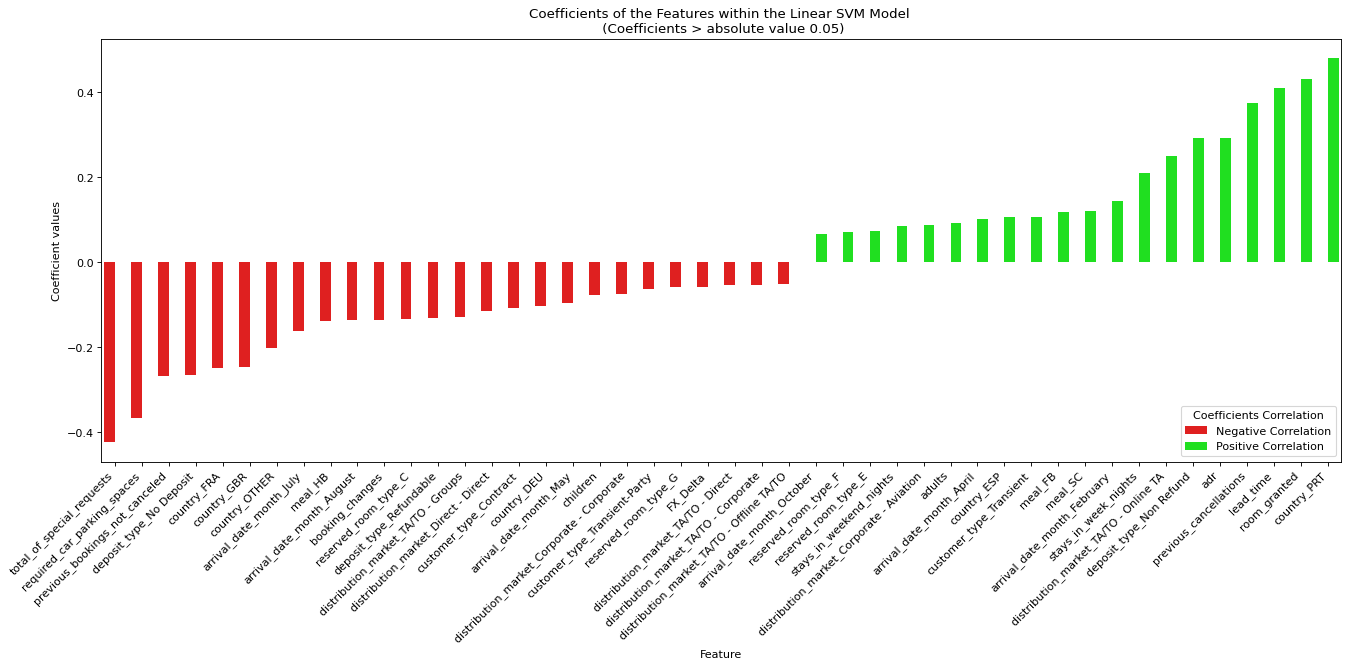

In [ ]:
SVM_Coefs = pd.DataFrame(svm_model.best_estimator_.steps[1][1].coef_[0], columns = {'coefficients'})
SVM_Coefs['Feature'] = d_onehot_labels[1:]
SVM_Coefs = SVM_Coefs.sort_values(by = 'coefficients' )
SVM_Coefs["Coefficients Correlation"] = np.where(SVM_Coefs["coefficients"]<0, 'Negative Correlation', 'Positive Correlation')
Tolerance = 0.05
#SVM_Coefs.drop(SVM_Coefs[(SVM_Coefs['coefficients'].eq(0)) | (abs(SVM_Coefs['coefficients']) < Tolerance )].index, inplace = True)
palette = {'Negative Correlation': "#ff0000", 'Positive Correlation': "#00ff00"}

fig, ax = plt.subplots(figsize=(20, 7)) 
feature_plot = sns.barplot(data = SVM_Coefs.drop(SVM_Coefs[(SVM_Coefs['coefficients'].eq(0)) | (abs(SVM_Coefs['coefficients']) < Tolerance )].index), 
                            y='coefficients',x = 'Feature' , hue = 'Coefficients Correlation' , ax=ax , palette=palette )

feature_plot.set_xticklabels(feature_plot.get_xticklabels(), rotation=45, horizontalalignment='right' )
#ax.set_xlabel('Features within the Lasso Model')
ax.set_ylabel('Coefficient values')
plt.title(f'Coefficients of the Features within the Linear SVM Model \n (Coefficients > absolute value {Tolerance})')
plt.show()

#Which feature numbers are far enough away from 0
#idx_above_threshold = np.argwhere(np.abs(importance) > 0.2)
#idx_above_threshold[1:5]



Shows that we how have a negative correlation with 'other' country. Inidividually, each of these countries has a negligible impact but now they are grouped and statistically more important, we gain some insight.

End of SVM Working 
______________


### Decision tree

scikit-learn implementation does not support categorical variables for now

Standarization might be useful if you intend to compare performance with other data or other methods like SVM.

Information gain being high when the sum of the impurity of the child nodes is low. Gini Impurity is an alternative measurement, which minimises the probabilty of misclassification. Since computing square is cheaper than logarithmic function we prefer Gini impurity over entropy.

Decision trees allow us assess the importance of each feature for classifying the data,

if decision trees are not pruned, they have a high risk of overfitting to the training data. An a priori limit on nodes, or tree depth, is often set to avoid overfitting due to a deep tree.

Important features mean the features that are more closely related with dependent variable and contribute more for variation of the dependent variable. We can not directly interpret them as how much change in Y is caused due to unit change in X(j), keeping all other features constant

In [ ]:
importances = DT.feature_importances_
importances_series = pd.Series(importances,index=feat_names).sort_values(ascending = False)
importances_series.plot.barh(legend =False, grid=False)

In [ ]:
#alpha_list = np.linspace(0.01, 15, num=100)
pipe = make_pipeline(
            DecisionTreeClassifier(
            random_state=42,
            criterion='gini'
        )) #max_depth = max_depth,

parameters = { 'decisiontreeclassifier__max_depth':list(range(1,20))}

kf = KFold(n_splits=5, shuffle=True, random_state=0)
models_tree = GridSearchCV(pipe, param_grid = parameters, scoring="accuracy", cv=kf,return_train_score=True)
models_tree.fit(X_train, y_train)

#n_iter = len(list(itertools.product(*list(iter(params.values())))))

y_hat = models_tree.predict(X_test)




In [ ]:
#models_tree.best_estimator_.predict_proba(X_test)
#models_tree.best_estimator_

# View the accuracy score
print('_____ GridSearchCV Tree Model Results_____')
print("Best Tree params: ", models_tree.best_params_)
print("Training set score for Tree: %f" % models_tree.score(X_train , y_train))
print("Testing  set score for Tree: %f" % models_tree.score(X_test  , y_test ))

# Now inspect the final model

print('_____ Final Logistic Regression Model Results_____')
final_model_tree= models_tree.best_estimator_
Y_pred_tree = models_tree.predict(X_test)


print('_____ Confusion Matrix_____ : \n',confusion_matrix(Y_pred_tree,y_test))
print('_____ Classification Report_____ : \n',classification_report(y_test,Y_pred_tree))
print('Coefficients for each feature are: \n')

print('% False positive for no cancellation',round(confusion_matrix(Y_pred_tree,y_test)[0,1]/ sum(confusion_matrix(Y_pred_tree,y_test)[0,:]),5)*100)
print('% False positive for cancellation',round(confusion_matrix(Y_pred_tree,y_test)[1,0]/ sum(confusion_matrix(Y_pred_tree,y_test)[1,:]),5)*100)


probs_tree = final_model_tree.predict_proba(X_test)



_____ GridSearchCV Tree Model Results_____
Best Tree params:  {'decisiontreeclassifier__max_depth': 16}
Training set score for Tree: 0.879711
Testing  set score for Tree: 0.845674
_____ Final Logistic Regression Model Results_____
_____ Confusion Matrix_____ : 
 [[13200  1951]
 [ 1734  6993]]
_____ Classification Report_____ : 
               precision    recall  f1-score   support

           0       0.87      0.88      0.88     14934
           1       0.80      0.78      0.79      8944

    accuracy                           0.85     23878
   macro avg       0.84      0.83      0.83     23878
weighted avg       0.85      0.85      0.85     23878

Coefficients for each feature are: 

% False positive for no cancellation 12.876999999999999
% False positive for cancellation 19.869


No handles with labels found to put in legend.


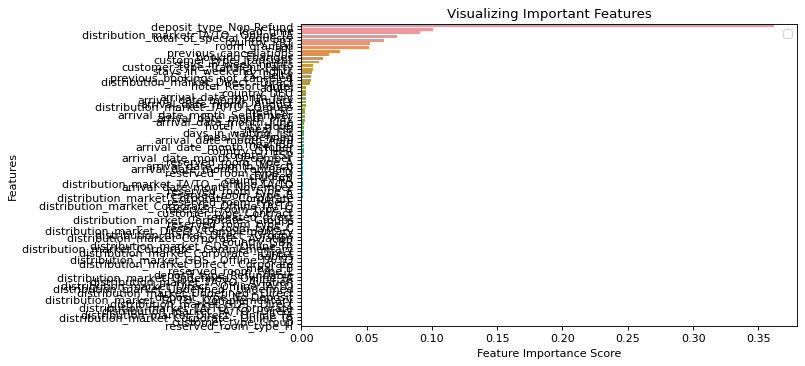

In [ ]:
importance_tree = models_tree.best_estimator_._final_estimator.feature_importances_

coefficients_tree_dict = dict(zip(X.columns, importance_tree))
coefficients_tree_dict
#feature_imp = pd.Series(clf.feature_importances_,index=iris.feature_names).sort_values(ascending=False)
#feature_imp

feature_imp = pd.Series(importance_tree,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()



In [ ]:
pd.DataFrame(feature_imp).sum()


0
deposit_type_Non Refund                    0.361649
lead_time                                  0.100509
distribution_market_TA/TO - Online TA      0.090817
total_of_special_requests                  0.073341
country_PRT                                0.063217
...                                             ...
distribution_market_TA/TO - Direct         0.000000
distribution_market_Direct - Online TA     0.000000
distribution_market_Corporate - Online TA  0.000000
customer_type_Group                        0.000000
reserved_room_type_H                       0.000000

[83 rows x 1 columns]

In [ ]:
import matplotlib
def fig2str(fig, format='svg'):
    """
    Return a string containing the raw data of the matplotlib figure in the given format.

    """
    assert isinstance(fig, matplotlib.figure.Figure)
    imgdata = BytesIO()
    fig.savefig(imgdata, format=format, bbox_inches='tight')
    imgdata.seek(0)  # rewind the data
    output = imgdata.getvalue()
    if format == 'svg':
        return output
    else:
        return urllib.parse.quote(base64.b64encode(output))

class MatplotlibFigure(object):
    """
    Thin wrapper around a matplotlib figure which provides a custom
    HTML representation that allows tweaking the appearance

    """
    def __init__(self, fig, centered=False):
        assert isinstance(fig, matplotlib.figure.Figure)
        self.centered = centered

    def _repr_html_(self):
        img_str_png = fig2str(fig, format='png')
        uri = 'data:image/png;base64,' + img_str_png
        html_repr = "<img src='{}'>".format(uri)
        if self.centered:
            html_repr = "<center>" + html_repr + "</center>"
        return html_repr

In [ ]:
cols = ["param_decisiontreeclassifier__max_depth", "mean_test_score", "mean_train_score"]

scores_df = pd.DataFrame(models_tree.cv_results_).sort_values("param_decisiontreeclassifier__max_depth")[cols]

scores_df = pd.melt(scores_df, value_vars=['mean_test_score','mean_train_score'],
                     id_vars=['param_decisiontreeclassifier__max_depth'], var_name = ['type'])

#fig_num+=1
gr = 1.618
height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

fig = plt.figure(figsize = (width_inch, height_inch))
sns.lineplot(data = scores_df, x='param_decisiontreeclassifier__max_depth', y = 'value', hue = 'type')
#plt.title('Figure %d: Tree Depth and Dataset Accuracy'%fig_num)
plt.close()
display(MatplotlibFigure(fig, centered=True))
#pd.DataFrame(models.cv_results_).sort_values("rank_test_score")[["param_decisiontreeclassifier__max_depth", "mean_test_score", "std_test_score"]].head()



In [ ]:
from sklearn import tree
tree.plot_tree(DT,feature_names=feature_names, 
                       class_names=class_names,
                       filled = True,
                           impurity = impurity)

### Random forest trees

 For now we will just examine the effect of `n_estimators` which corresponds to the number of trees and `max_depth` which is the maximum depth of the trees.

In [ ]:
#alpha_list = np.linspace(0.01, 15, num=100)
pipe_random_forest = make_pipeline(
            RandomForestClassifier(
            random_state=42,
            criterion='gini'
        )) #max_depth = max_depth,

parameters = { 'randomforestclassifier__max_depth':list(range(1,20)),
                'randomforestclassifier__n_estimators': list(range(1,100))}

kf = KFold(n_splits=5, shuffle=True, random_state=0)
models_tree_random = GridSearchCV(pipe_random_forest, param_grid = parameters, scoring="accuracy", cv=kf,return_train_score=True)
models_tree_random.fit(X_train, y_train)

#n_iter = len(list(itertools.product(*list(iter(params.values())))))

y_hat_random_forest = models_tree_random.predict(X_test)
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
# View the accuracy score
print('_____ GridSearchCV Random Forest Model Results_____')
print("Best SVC params: ", models_tree_random.best_params_)
print("Training set score for Random Forest: %f" % models_tree_random.score(X_train , y_train))
print("Testing  set score for Random Forest: %f" % models_tree_random.score(X_test  , y_test ))

# Now inspect the final model
final_model = models_tree_random.best_estimator_
#Y_pred_svm = models_tree_random.predict(X_test)

print('_____ Final SVM Model Results_____')

print('_____ Confusion Matrix_____ : \n',confusion_matrix(y_hat_random_forest,y_test))
print('_____ Classification Report_____ : \n',classification_report(y_test,y_hat_random_forest))

_____ GridSearchCV Random Forest Model Results_____
Best SVC params:  {'randomforestclassifier__max_depth': 9, 'randomforestclassifier__n_estimators': 8}
Training set score for Random Forest: 0.868063
Testing  set score for Random Forest: 0.799163
_____ Final SVM Model Results_____
_____ Confusion Matrix_____ : 
 [[139  44]
 [  4  52]]
_____ Classification Report_____ : 
               precision    recall  f1-score   support

           0       0.76      0.97      0.85       143
           1       0.93      0.54      0.68        96

    accuracy                           0.80       239
   macro avg       0.84      0.76      0.77       239
weighted avg       0.83      0.80      0.79       239



Accuracy: 0.799163179916318
No handles with labels found to put in legend.


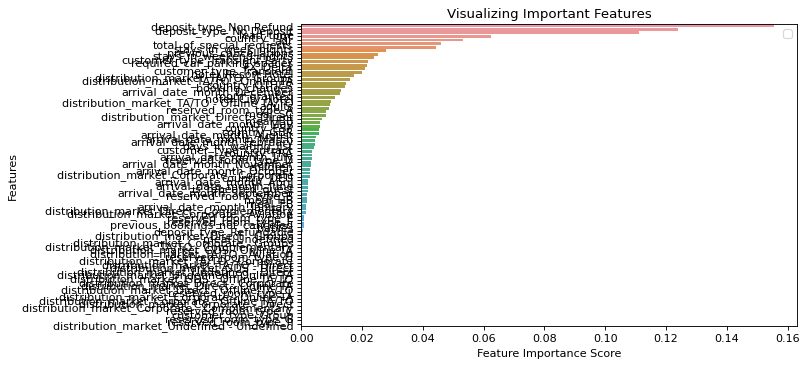

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_hat_random_forest))
importance_tree_random = models_tree_random.best_estimator_._final_estimator.feature_importances_

feature_imp_tree_random = pd.Series(importance_tree_random,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp_tree_random, y=feature_imp_tree_random.index)


# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## 4. Discussion & Conclusions


In [ ]:
Merg_coef = pd.merge(SVM_Coefs.drop(['Coefficients Correlation'], axis = 1), logReg_Coefs.drop(['Coefficients Correlation'], axis = 1), on = 'Feature')
Merg_coef.columns = ['SVM_Coefs', 'Feature','LogReg_Coefs' ]

In [ ]:
def categorical_data_viewer(DataFrame, StartsWith = '', Tolerance = 0 , DeleteZeros = 'Y', WhatCoef = 'Both' ):
    DataFrame = DataFrame[DataFrame['Feature'].str.match(StartsWith)]
    DataFrame['Feature'] = DataFrame['Feature'].str.replace((StartsWith+'_'),'')
    
    if DeleteZeros == 'Y':
        DataFrame.drop(DataFrame[(DataFrame['SVM_Coefs'].eq(0)) | (abs(DataFrame['SVM_Coefs']) < Tolerance )].index, inplace = True)
        DataFrame.drop(DataFrame[(DataFrame['LogReg_Coefs'].eq(0)) | (abs(DataFrame['LogReg_Coefs']) < Tolerance )].index, inplace = True)
    else:
        DataFrame.drop(DataFrame[(abs(DataFrame['SVM_Coefs']) < Tolerance )].index, inplace = True)
        DataFrame.drop(DataFrame[(abs(DataFrame['LogReg_Coefs']) < Tolerance )].index, inplace = True)
    if WhatCoef == 'SVM':
        DataFrame.drop(['LogReg_Coefs'],axis = 1, inplace = True)
    elif WhatCoef == 'LogReg':
        DataFrame.drop(['LogReg_Coefs'],axis = 1, inplace = True)
    
    return DataFrame

#### Country Discussion

The decision to group countires into "Other" for countires which consitute for less that 5% of all bookings has allowed the results to show that these countries are unlikely to cancel compared to any of the countires with many visitors. Countries like Fuji or Uzbeckistan only had 1 visitor to either of the hotels, 

In [ ]:
country_coefs = categorical_data_viewer(Merg_coef, StartsWith = 'country', Tolerance = 0.05 , DeleteZeros = 'N', WhatCoef = 'SVM' )
country_coefs = pd.merge(country_coefs, d_FULL[['country', 'distance(km)', 'Region Name', 'country_name']], left_on = 'Feature', right_on='country', how = 'left')
#sns.scatterplot(data=country_coefs, x="distance(km)", y="SVM_Coefs", hue="country", style="Region Name")
fig = px.scatter(country_coefs, x="distance(km)", y="SVM_Coefs", color="country", hover_data=['country','Region Name' ])
fig.show()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of the client who is with the hotel data and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

## 5. Convert Document

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf proj2.ipynb

[NbConvertApp] Converting notebook proj2.ipynb to pdf
[NbConvertApp] Writing 49741 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 72102 bytes to proj2.pdf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6d844b8b-c2b2-41b2-8d9c-38e9bb4a0873' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>